In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

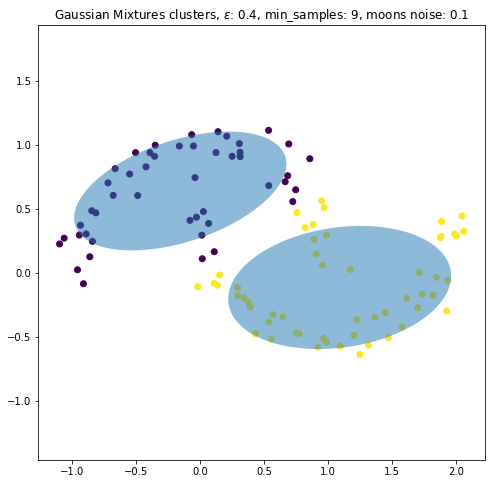

In [14]:
# Ellipse visualization from sklearn documentation:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
def make_ellipses(gmm, ax):
#     colors = ['red', 'green']
    for n in range(gmm.covariances_.shape[0]):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle)#, color=colors[n])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

from sklearn.mixture import GaussianMixture
noise = 0.1
X, y = make_moons(n_samples=100, noise=noise, random_state=0)
eps = 0.4
min_samples = 9
gm = GaussianMixture(n_components=2,
                      covariance_type='full', # 'tied', 'diag', 'spherical'
                      tol=0.001, # lower bound gain that EM optimizess until
                      reg_covar=1e-6, # Regularization added to diag. of covariance matrix
                                      # so that they're all positive
                      max_iter=100, 
                      n_init=1,
                      init_params='kmeans', # 'random'
                      weights_init=None, # weights for different distributions shape: (n_components,)
                      means_init=None, # custom initialization for all the means, shape: (n_components, n_features)
                      precisions_init=None, # custom initialization for precision, shape depends on covariance_type
                      random_state=None,
                      warm_start=False,
                      verbose=0, # higher is more output
                      verbose_interval=10 # number of iterations between subsequent verbose based outputs
                     )
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(X[:, 0], X[:, 1], c=gm.fit_predict(X))
plt.title(f'Gaussian Mixtures clusters, $\epsilon$: {eps}, min_samples: {min_samples}, moons noise: {noise}')
make_ellipses(gm, ax)
plt.show()

In [3]:
print(gm.weights_) # weights of each component
print(gm.means_) # means of each distribution
print(gm.covariances_) # covariances of each distribution
print(gm.precisions_) # precision matrix of each distribution
print(gm.converged_) # if converged
print(gm.n_iter_) # number of iterations training ran for
print(gm.lower_bound_) # lower bound of log-likelihood of EM process on our training data for our current model

[0.47306018 0.52693982]
[[-0.15700622  0.64052702]
 [ 1.09009278 -0.11406887]]
[[[0.34501674 0.08805124]
  [0.08805124 0.10812566]]

 [[0.3802938  0.03962325]
  [0.03962325 0.11601829]]]
[[[ 3.65880946 -2.97952123]
  [-2.97952123 11.67484712]]

 [[ 2.72656802 -0.93119352]
  [-0.93119352  8.93735719]]]
True
5
-1.7670180828373694


In [4]:
print(gm.aic(X))
print(gm.bic(X))

375.31661759839017
403.9734896442592


In [5]:
# gm.predict(X)
# gm.predict_proba(X)

In [6]:
print(gm.score(X)) # avg. log-likelihood over samples
print(gm.score_samples(X).shape) # log prob. density per sample

-1.7665830879919509
(100,)


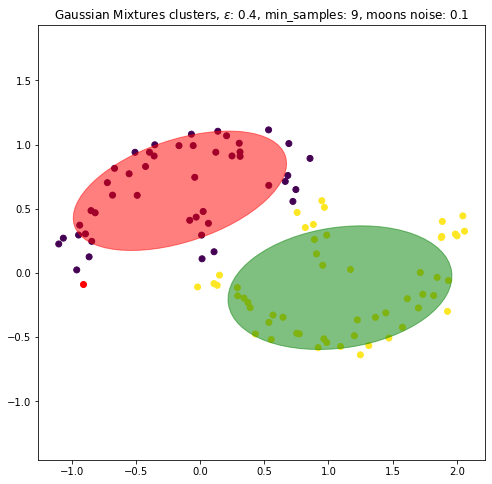

In [7]:
logProbDensities = gm.score_samples(X)
sortedVals = np.array(sorted([[x, y] for x,y in zip(logProbDensities, range(len(logProbDensities)))],
                             key= lambda x: x[0]))
percent = 1
outliers = sortedVals[:int(len(sortedVals)/100*percent),1]
notOutliers = sortedVals[int(len(sortedVals)/100*percent):,1]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(X[outliers.astype(int), 0], X[outliers.astype(int), 1], c='red')
plt.scatter(X[notOutliers.astype(int), 0], X[notOutliers.astype(int), 1], c=gm.predict(X[notOutliers.astype(int)]))
plt.title(f'Gaussian Mixtures clusters, $\epsilon$: {eps}, min_samples: {min_samples}, moons noise: {noise}')
make_ellipses(gm, ax)
plt.show()

In [8]:
print(gm.sample(n_samples=5)) # generate samples from our distributions

(array([[-0.78848879,  0.4375952 ],
       [-1.33641402,  0.89828408],
       [-0.80305152,  1.30316894],
       [ 1.22198226, -0.08347798],
       [ 1.29824833,  0.29494505]]), array([0, 0, 0, 1, 1]))


In [17]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=2,
                              covariance_type='full',
                              tol=0.001,
                              reg_covar=1e-6,
                              max_iter=100,
                              n_init=1,
                              init_params='kmeans',
                              # control prior probability structure
                              weight_concentration_prior_type='dirichlet_process',
                              # 'dirichlet_distribution' <- leads to more uniforms weights across the different 
                              # gaussian distributions
                              weight_concentration_prior=None, 
                              mean_precision_prior=None, # float, controls where distributions can be placed
                              # larger values lead to distributions grouping around mean_prior
                              mean_prior=None, # (n_features,), priot mean distribution, otherwise set to mean of
                              # each feature in X
                              degrees_of_freedom_prior=None, # prior for d.o.f. for cov. matrix
                              covariance_prior=None, # prior on cov. matrix, shape depends on cov. type
                              random_state=None,
                              warm_start=False,
                              verbose=0,
                              verbose_interval=10
                             )

/Users/maxschallwig/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


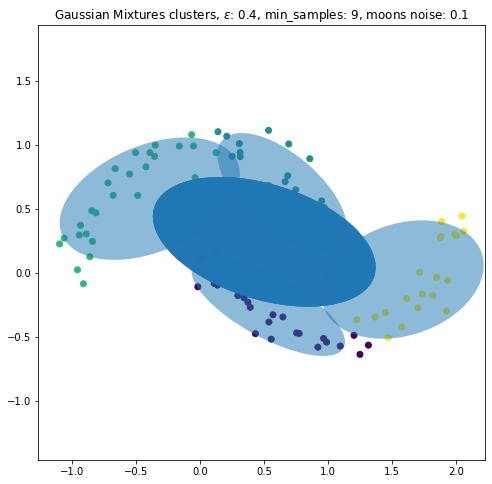

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(X[:, 0], X[:, 1], c=bgm.fit_predict(X))
plt.title(f'Gaussian Mixtures clusters, $\epsilon$: {eps}, min_samples: {min_samples}, moons noise: {noise}')
make_ellipses(bgm, ax)
plt.show()